### Daniel Howard, dah2183, QMSS 5074, Spring 2020 HW2

### Assignment #2: Write up a report that makes use of brain tumor diagnostic MRI image data

### Github Link : https://github.com/dhoward0497/QMSS5074_HW2

#### Please note, all the code and plots are presented below. The write up of the report and any findings found are typed up after the code and at the end of this documet.

### **Load libraries , unpack data and visualize images**

In [69]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os

import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications  import VGG19, ResNet50, InceptionV3, MobileNetV2

from keras.preprocessing import image
from keras.preprocessing.image import load_img
import numpy as np
from PIL import Image

from itertools import repeat
import pandas as pd
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

import pickle

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot 


from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.callbacks import ModelCheckpoint

! pip3 install https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.5.tar.gz?raw=true
import aimodelshare as ai

  Using cached https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.5.tar.gz?raw=true
  Created wheel for aimodelshare: filename=aimodelshare-0.0.5-cp36-none-any.whl size=5305 sha256=741c3d95d94b6e57ef9397dae8238523a5b4a37652bdd3c69499eaa04b1b51db
  Stored in directory: /root/.cache/pip/wheels/ab/28/ae/b9ecb7a3a5542d3f2fed56649fdd6dec1c16f900ef70b93875
Successfully built aimodelshare


In [0]:
# After saving the zip file to the working directory, extract all files and folders from zip file to local folder.

!unzip brain_tumor_dataset.zip  


Archive:  brain_tumor_dataset.zip
replace brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [70]:
# Extracting all filenames iteratively from brain_tumor_dataset folder
base_path = 'brain_tumor_dataset'
categories = ['yes', 'no']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

# function for loading images
def load_image(img_path):
        img = Image.open(img_path).convert("RGB").resize((224,224)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-np.float32(img).min())/(np.float32(img).max()-np.float32(img).min()) # min max transformation
        img=img.reshape((224,224,3)) # Create final shape as array with correct dimensions for Keras
        return img

# read in all images from filenames
preprocessed_image_data=list(map(load_image, fnames[0]+fnames[1]))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X = np.array(preprocessed_image_data) # X is feature input data for the model

# Create y data made up of correctly ordered labels from file folders
yes=list(repeat("yes", 155))
no=list(repeat("no", 98))
y_labels = yes+no
y = pd.get_dummies(y_labels)

# check length y = x
print("The #y = the #x.", len(y) == len(X))

The #y = the #x. True


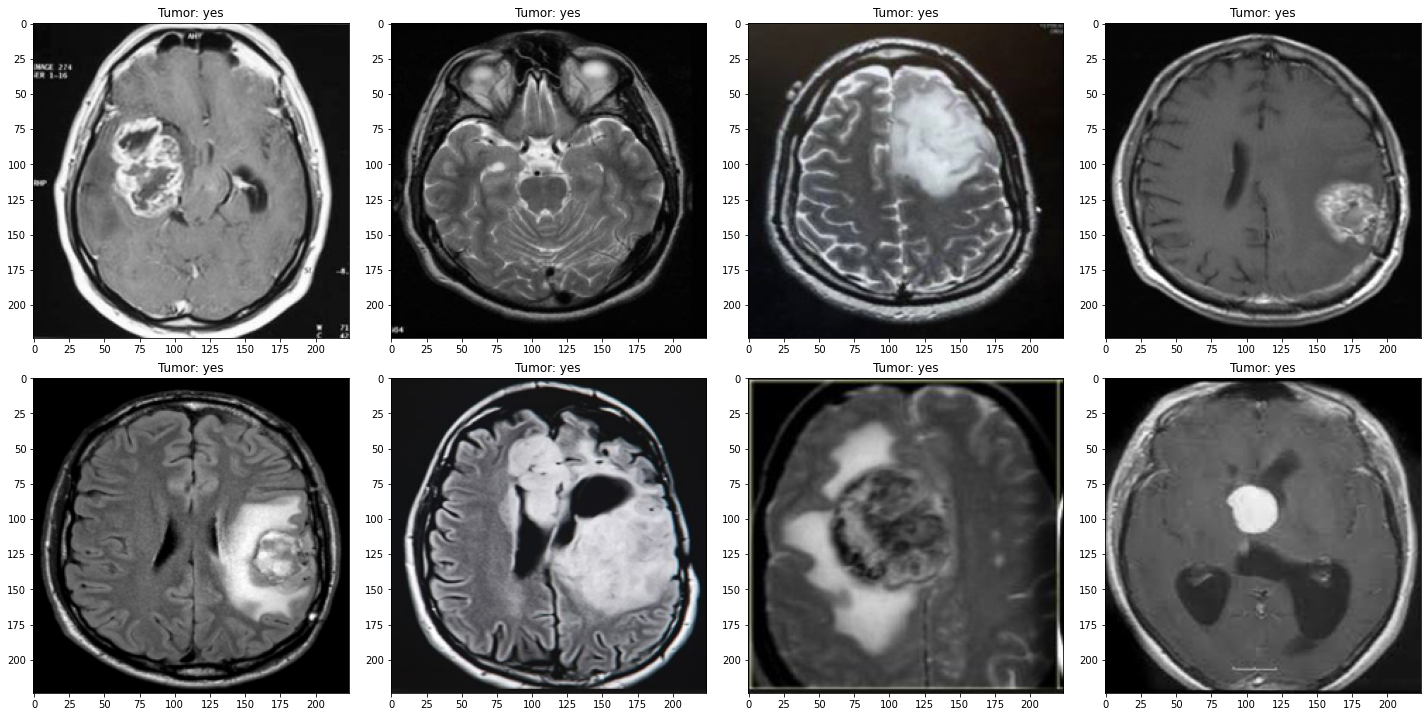

In [0]:
# for images with tumors ("yes")

fig,ax=plt.subplots(2,4)
fig.set_size_inches(20,10)
shown = []
for i in range(2):
    for j in range (4):
        l = np.random.randint(0,len(yes))
        if l in shown: # make sure the same image isn't plotted twice
          l = np.random.randint(0,len(yes))
        shown.append(l)
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Tumor: '+ y_labels[l])
        
plt.tight_layout()

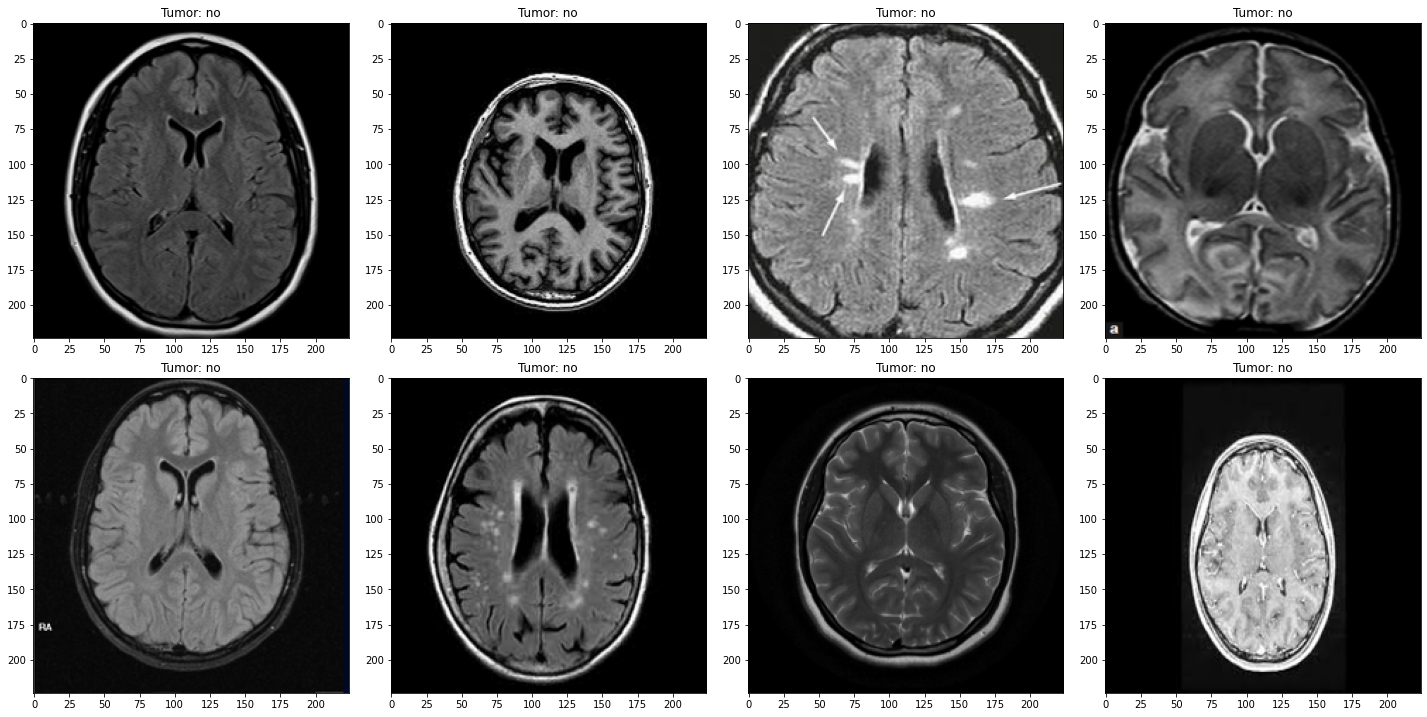

In [0]:
# for images with tumors ("no")

fig,ax=plt.subplots(2,4)
fig.set_size_inches(20,10)
shown = []
for i in range(2):
    for j in range (4):
        l = np.random.randint(0,len(no)) + len(yes)
        if l in shown: # make sure the same image isn't plotted twice
          l = np.random.randint(0,len(no)) + len(yes)
        shown.append(l)
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Tumor: '+ y_labels[l])
        
plt.tight_layout()

In [0]:
# for images of form 4 x 2

def show_4x2_images():
  fig,ax=plt.subplots(2,4)
  fig.set_size_inches(20,10)
  shown = []
  for i in range(1):
      for j in range (4):
          l = np.random.randint(0,len(no)) + len(yes)
          if l in shown: # make sure the same image isn't plotted twice
            l = np.random.randint(0,len(no)) + len(yes)
          shown.append(l)
          ax[i,j].imshow(X[l])
          ax[i,j].set_title('Tumor: '+ y_labels[l])
          
  shown = []
  for i in range(1,2):
      for j in range (4):
          l = np.random.randint(0,len(yes))
          if l in shown: # make sure the same image isn't plotted twice
            l = np.random.randint(0,len(yes))
          shown.append(l)
          ax[i,j].imshow(X[l])
          ax[i,j].set_title('Tumor: '+ y_labels[l])
          
  plt.tight_layout()

### **Prediction Models**

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.callbacks import EarlyStopping

In [0]:
### Train test split resized images

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)

#### model_1 - first NN with 5 layers and 15 epochs

In [0]:

opt=SGD(lr=.001)

model = Sequential()

# Layers
model.add(Dense(64,  input_shape=(224, 224, 3), activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Flatten())

model.add(Dense(2, activation='softmax')) 

# Checkpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5, min_lr=0.0001) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs                                                

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Fitting the NN to the Training set
model.fit(X_train, y_train, 
              epochs = 15, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])

Epoch 1/15
7/7 [==============================] - ETA: 0s - loss: 0.6110 - accuracy: 0.6287
Epoch 00001: val_accuracy improved from -inf to 0.52941, saving model to best_model.h5
7/7 [==============================] - 1s 159ms/step - loss: 0.6110 - accuracy: 0.6287 - val_loss: 0.7538 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 2/15
7/7 [==============================] - ETA: 0s - loss: 0.6158 - accuracy: 0.6485
Epoch 00002: val_accuracy did not improve from 0.52941
7/7 [==============================] - 1s 123ms/step - loss: 0.6158 - accuracy: 0.6485 - val_loss: 0.6178 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 3/15
7/7 [==============================] - ETA: 0s - loss: 0.5839 - accuracy: 0.7030
Epoch 00003: val_accuracy improved from 0.52941 to 0.62745, saving model to best_model.h5
7/7 [==============================] - 1s 129ms/step - loss: 0.5839 - accuracy: 0.7030 - val_loss: 0.5791 - val_accuracy: 0.6275 - lr: 0.0010
Epoch 4/15
7/7 [==============================] - ETA: 0s - loss: 

In [0]:
# save best model as model_1
model.load_weights('best_model.h5')
model_1 = model
model_1.save_weights('best_model_1.h5')
model_1.load_weights('best_model_1.h5') ### load the best model

#### model_2 - 2nd CNN 2 with multipl layers and 25 epochs

In [0]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([

      # convolutional layer 
      tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu', input_shape=[224, 224, 3]),
      tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', data_format="channels_first", activation='linear'),
      tf.keras.layers.BatchNormalization(axis=1,epsilon=0.001),
      tf.keras.layers.MaxPooling2D(pool_size=(3,3)),

      # convolutional layer 
      tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='linear'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', data_format="channels_first", activation='relu'),
      tf.keras.layers.BatchNormalization(axis=1,epsilon=0.001),
      tf.keras.layers.MaxPooling2D(pool_size=(3,3)),

      # convolutional layer 
      tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='linear'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', data_format="channels_first", activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(3,3)),

      # convolutional layer 
      tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='linear'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', data_format="channels_first", activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),

      # convolutional layer 
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='linear'),
      tf.keras.layers.Conv2D(kernel_size=2, filters=32, padding='same', data_format="channels_first", activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),

      # convolutional layer 
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='linear'),
      tf.keras.layers.Conv2D(kernel_size=2, filters=32, padding='same', activation='linear'),
      tf.keras.layers.MaxPooling2D(pool_size=2),

      # convolutional layer 
      tf.keras.layers.Conv2D(kernel_size=2, filters=16, padding='same', activation='linear'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),

      # Flatten
      tf.keras.layers.Flatten(),

      # Full connection 
      tf.keras.layers.Dense(2, activation='softmax')
  ])

  # Checkpoint
  mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr = ReduceLROnPlateau(monitor='val_accuracy',patience=4,verbose=0,factor=0.5, mode = "max") # dividing lr by 10 when val_accuracy fails to improve after 3 epochs                                                

  model.compile(
      optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
      loss= 'categorical_crossentropy',
      metrics=['accuracy'])

  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                  epochs = 25, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])

Epoch 1/25
7/7 [==============================] - ETA: 0s - loss: 0.8120 - accuracy: 0.5099
Epoch 00001: val_accuracy improved from -inf to 0.52941, saving model to best_model.h5
7/7 [==============================] - 1s 192ms/step - loss: 0.8120 - accuracy: 0.5099 - val_loss: 0.6802 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 2/25
6/7 [========================>.....] - ETA: 0s - loss: 0.6088 - accuracy: 0.7031
Epoch 00002: val_accuracy improved from 0.52941 to 0.76471, saving model to best_model.h5
7/7 [==============================] - 1s 96ms/step - loss: 0.6746 - accuracy: 0.6881 - val_loss: 0.6770 - val_accuracy: 0.7647 - lr: 0.0010
Epoch 3/25
6/7 [========================>.....] - ETA: 0s - loss: 0.7460 - accuracy: 0.6198
Epoch 00003: val_accuracy did not improve from 0.76471
7/7 [==============================] - 1s 86ms/step - loss: 0.7009 - accuracy: 0.6287 - val_loss: 0.6773 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 4/25
6/7 [========================>.....] - ETA: 0s - loss: 0.

In [0]:
# save best model as model_2
model_2 = model
model_2.load_weights('best_model.h5')
model_2.save_weights('best_model_2.h5') ## troubleshooting so that Sequential not Histroy model is used as that is what is required for model upload

#### model_3 - uses VGG19 and "ImageNet" dataset for transfer learning

In [82]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape = (224,224,3)) ## ImageNet dataset is used for transfer learning when setting up VGG19 model

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(2),
])

mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
red_lr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=0,factor=0.5, mode = "max") 

model.compile(
      optimizer="adam",
      loss= 'categorical_crossentropy',
      metrics=['accuracy'])


# Fitting to the Training set
model.fit(X_train, y_train,
          epochs = 25, verbose=1,
          validation_data=(X_test,y_test),
          callbacks=[mc,red_lr])


Epoch 1/25
7/7 [==============================] - ETA: 0s - loss: 6.1162 - accuracy: 0.3663
Epoch 00001: val_accuracy improved from -inf to 0.47059, saving model to best_model.h5
7/7 [==============================] - 2s 309ms/step - loss: 6.1162 - accuracy: 0.3663 - val_loss: 7.5951 - val_accuracy: 0.4706 - lr: 0.0010
Epoch 2/25
7/7 [==============================] - ETA: 0s - loss: 5.4830 - accuracy: 0.3663
Epoch 00002: val_accuracy did not improve from 0.47059
7/7 [==============================] - 2s 228ms/step - loss: 5.4830 - accuracy: 0.3663 - val_loss: 7.5951 - val_accuracy: 0.4706 - lr: 0.0010
Epoch 3/25
7/7 [==============================] - ETA: 0s - loss: 6.2745 - accuracy: 0.3663
Epoch 00003: val_accuracy did not improve from 0.47059
7/7 [==============================] - 2s 227ms/step - loss: 6.2745 - accuracy: 0.3663 - val_loss: 7.5951 - val_accuracy: 0.4706 - lr: 0.0010
Epoch 4/25
7/7 [==============================] - ETA: 0s - loss: 6.2745 - accuracy: 0.3663
Epoch 000

In [0]:
# save best model as model_2
model.load_weights('best_model.h5')
model_3 = model
model_3.save_weights('best_model_3.h5')
model_3.load_weights('best_model_3.h5') ### load the best model

### **Model Comparison/Evaluation**

In [0]:
def model_scores(model_name):

  def predict_classes(x): # adjusted from keras github code
    proba=x
    if proba.shape[-1] > 1:
        return proba.argmax(axis=-1)
    else:
        return (proba > 0.5).astype("int32")

  mymodel = model_name

  raw_predictions=mymodel.predict(X_test)

  prediction_index=predict_classes(raw_predictions)

  #Now lets run some code to get keras to return the label rather than the index...

  # get labels from one hot encoded y_train data
  labels=pd.get_dummies(y_train).columns

  # Iterate through all predicted indices using map method

  predicted_labels=list(map(lambda x: labels[x], prediction_index))
  y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object


  def model_eval_metrics(y_true, y_pred,classification="TRUE"):
      if classification=="TRUE":
          accuracy_eval = accuracy_score(y_true, y_pred)
          f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
          precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
          recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
          mse_eval = 0
          rmse_eval = 0
          mae_eval = 0
          r2_eval = 0
          metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval],
                        'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
          finalmetricdata = pd.DataFrame.from_dict(metricdata)
      else:
          accuracy_eval = 0
          f1_score_eval = 0
          precision_eval = 0
          recall_eval = 0
          mse_eval = mean_squared_error(y_true, y_pred)
          rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
          mae_eval = mean_absolute_error(y_true, y_pred)
          r2_eval = r2_score(y_true, y_pred)
          metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval],
                        'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
          finalmetricdata = pd.DataFrame.from_dict(metricdata)
      return finalmetricdata

  output = model_eval_metrics(y_test_labels,predicted_labels,classification="TRUE")

  return output

  def model_eval_metrics(y_true, y_pred,classification="TRUE"):
      if classification=="TRUE":
          accuracy_eval = accuracy_score(y_true, y_pred)
          f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
          precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
          recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
          mse_eval = 0
          rmse_eval = 0
          mae_eval = 0
          r2_eval = 0
          metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval],
                        'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
          finalmetricdata = pd.DataFrame.from_dict(metricdata)
      else:
          accuracy_eval = 0
          f1_score_eval = 0
          precision_eval = 0
          recall_eval = 0
          mse_eval = mean_squared_error(y_true, y_pred)
          rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
          mae_eval = mean_absolute_error(y_true, y_pred)
          r2_eval = r2_score(y_true, y_pred)
          metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval],
                        'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
          finalmetricdata = pd.DataFrame.from_dict(metricdata)
      return finalmetricdata

In [0]:
model_scores(model_1)

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.843137,0.841615,0.845611,0.840278,0,0,0,0


In [0]:
model_scores(model_2)

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.862745,0.862745,0.865741,0.865741,0,0,0,0


In [84]:
model_scores(model_3)

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.470588,0.32,0.235294,0.5,0,0,0,0


### **Submit model to AI Model Share**

In [0]:
### BEST MODEL NOW FINAL_MODEL : 
final_model = model_2

In [0]:
#install aimodelshare library (version 0.0.3 last updated 3/6/2020)
! pip3 install https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.5.tar.gz?raw=true
import aimodelshare as ai

# arguments required to get leaderboard below
apiurl="https://a53yv0xqce.execute-api.us-east-1.amazonaws.com/prod/m"
username = "******"
password = "******"

aws_key_password_region = pickle.load( open( "braintumor_modelsubmission_keys.pkl", "rb" ) )

aws_key=aws_key_password_region[0]
aws_password=aws_key_password_region[1]
region=aws_key_password_region[2]

leaderboard = ai.get_leaderboard(apiurl, username, password, aws_key, aws_password, region)

  Using cached https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.5.tar.gz?raw=true
  Created wheel for aimodelshare: filename=aimodelshare-0.0.5-cp36-none-any.whl size=5305 sha256=c8f8c33d6da894b42682a9e6cc22f4387ab11d498d4228a1bcd8bb5dc4df2561
  Stored in directory: /root/.cache/pip/wheels/ab/28/ae/b9ecb7a3a5542d3f2fed56649fdd6dec1c16f900ef70b93875
Successfully built aimodelshare


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2,username,model_version,avg_ranking_classification,avg_ranking_regression,model_config,model_optim_config,model_epochs
15,0.941176,0.940812,0.942547,0.939815,0,0,0,0,Taketo,17,1.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
14,0.901961,0.901354,0.902950,0.900463,0,0,0,0,Taketo,16,2.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",10
16,0.875000,0.868718,0.868718,0.868718,0,0,0,0,3scman,18,3.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.01, 'decay...",25
21,0.862745,0.862745,0.865741,0.865741,0,0,0,0,dhoward97,24,4.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 1.5625e-05, ...",25
23,0.862745,0.862534,0.862308,0.863426,0,0,0,0,seanmcalevey,26,5.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",50
17,0.823529,0.813187,0.875000,0.812500,0,0,0,0,AlisaAi,19,5.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",25
20,0.843137,0.841615,0.845611,0.840278,0,0,0,0,seanmcalevey,23,6.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",25
13,0.803922,0.802019,0.805643,0.800926,0,0,0,0,Taketo,15,8.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
12,0.784314,0.778873,0.796053,0.777778,0,0,0,0,SUN-Wenjun,14,9.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",20
3,0.784314,0.775690,0.808824,0.775463,0,0,0,0,username1,5,9.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5


In [0]:
!pip3 install onnx
!pip3 install keras2onnx
!pip3 install onnxruntime


In [0]:
# get metrics

import os
os.environ['TF_KERAS'] = '1' # Add this environmental variable whenever you use tensorflow's tf.keras to build your keras model
import onnx
import keras2onnx
import onnxruntime

from keras2onnx import convert_keras
onx = convert_keras(final_model, 'my_model.onnx')
with open("my_model.onnx", "wb") as f:
    f.write(onx.SerializeToString())

def predict_classes(x):
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

mymodel = final_model

raw_predictions=mymodel.predict(X_test)

prediction_index=predict_classes(raw_predictions)

labels=pd.get_dummies(y_train).columns

predicted_labels=list(map(lambda x: labels[x], prediction_index))

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

y_test_labels=y_test.idxmax(axis=1)

modelevalobject=model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")


In [0]:
model_filepath = "my_model.onnx"

In [0]:
# import model
import aimodelshare as ai

ai.submit_model(model_filepath=model_filepath, model_eval_metrics=modelevalobject,modelobject=model,apiurl=apiurl, username=username, password=password, aws_key=aws_key,aws_password=aws_password, region=region, trainingdata="default",preprocessor_filepath="default",preprocessor="default")



"my_model.onnx" has been loaded to version 24 of your prediction API.
This version of the model will be used by your prediction api for all future predictions automatically.
If you wish to use an older version of the model, please reference the getting started guide at aimodelshare.com.


In [0]:
# check leaderboard

leaderboard = ai.get_leaderboard(apiurl, username, password, aws_key, aws_password, region)

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2,username,model_version,avg_ranking_classification,avg_ranking_regression,model_config,model_optim_config,model_epochs
15,0.941176,0.940812,0.942547,0.939815,0,0,0,0,Taketo,17,1.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
14,0.901961,0.901354,0.902950,0.900463,0,0,0,0,Taketo,16,2.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",10
16,0.875000,0.868718,0.868718,0.868718,0,0,0,0,3scman,18,3.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.01, 'decay...",25
21,0.862745,0.862745,0.865741,0.865741,0,0,0,0,dhoward97,24,4.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 1.5625e-05, ...",25
23,0.862745,0.862534,0.862308,0.863426,0,0,0,0,seanmcalevey,26,5.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",50
17,0.823529,0.813187,0.875000,0.812500,0,0,0,0,AlisaAi,19,5.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",25
20,0.843137,0.841615,0.845611,0.840278,0,0,0,0,seanmcalevey,23,6.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",25
13,0.803922,0.802019,0.805643,0.800926,0,0,0,0,Taketo,15,8.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
12,0.784314,0.778873,0.796053,0.777778,0,0,0,0,SUN-Wenjun,14,9.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",20
3,0.784314,0.775690,0.808824,0.775463,0,0,0,0,username1,5,9.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5


### **Import and fit the best model from the leader board to training data**

In [0]:
# get leaderboard
import aimodelshare as ai
leaderboard = ai.get_leaderboard(apiurl, username, password, aws_key, aws_password, region)

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2,username,model_version,avg_ranking_classification,avg_ranking_regression,model_config,model_optim_config,model_epochs
15,0.941176,0.940812,0.942547,0.939815,0,0,0,0,Taketo,17,1.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
14,0.901961,0.901354,0.902950,0.900463,0,0,0,0,Taketo,16,2.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",10
16,0.875000,0.868718,0.868718,0.868718,0,0,0,0,3scman,18,3.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.01, 'decay...",25
21,0.862745,0.862745,0.865741,0.865741,0,0,0,0,dhoward97,24,4.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 1.5625e-05, ...",25
23,0.862745,0.862534,0.862308,0.863426,0,0,0,0,seanmcalevey,26,5.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",50
17,0.823529,0.813187,0.875000,0.812500,0,0,0,0,AlisaAi,19,5.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",25
20,0.843137,0.841615,0.845611,0.840278,0,0,0,0,seanmcalevey,23,6.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",25
13,0.803922,0.802019,0.805643,0.800926,0,0,0,0,Taketo,15,8.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
12,0.784314,0.778873,0.796053,0.777778,0,0,0,0,SUN-Wenjun,14,9.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",20
3,0.784314,0.775690,0.808824,0.775463,0,0,0,0,username1,5,9.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5


In [77]:
from tensorflow.keras.models import model_from_yaml
# Import model from leaderboard
index_pos = 15 # index number of the top row
model_config= leaderboard.loc[index_pos,'model_config'] # model details best model (i.e.-row #1)
model_optim_config= leaderboard.loc[index_pos,'model_optim_config'] # model details best model (i.e.-row #1)

leaderboard_model = model_from_yaml(model_config)
leaderboard_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 32,738
Non-trainable params: 21,774,144
_________________________________________________________________


In [78]:
model_optim_config

"{'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}"

In [0]:
my_model_optim_config = leaderboard.loc[21,'model_optim_config']
my_model_optim_config

"{'name': 'Adam', 'learning_rate': 1.5625e-05, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}"

In [79]:
leaderboard_model.compile(
      optimizer="adam",
      loss= 'categorical_crossentropy',
      metrics=['accuracy'])

# Fitting to the Training set
leaderboard_model.fit(X_train, y_train,
          epochs = 5, verbose=1,
          validation_data=(X_test,y_test))

model_scores(leaderboard_model)

Epoch 1/5
7/7 [==============================] - 2s 267ms/step - loss: 0.6813 - accuracy: 0.5990 - val_loss: 0.6921 - val_accuracy: 0.5294
Epoch 2/5
7/7 [==============================] - 1s 114ms/step - loss: 0.6492 - accuracy: 0.6337 - val_loss: 0.6896 - val_accuracy: 0.5294
Epoch 3/5
7/7 [==============================] - 1s 114ms/step - loss: 0.6420 - accuracy: 0.6337 - val_loss: 0.6869 - val_accuracy: 0.5294
Epoch 4/5
7/7 [==============================] - 1s 114ms/step - loss: 0.6161 - accuracy: 0.6337 - val_loss: 0.6855 - val_accuracy: 0.5294
Epoch 5/5
7/7 [==============================] - 1s 113ms/step - loss: 0.6168 - accuracy: 0.6337 - val_loss: 0.6839 - val_accuracy: 0.5294


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.529412,0.346154,0.264706,0.5,0,0,0,0


### **Write up of the report**

There are many advantages that can come from modeled interpretations (predictions) of medical image data. Convolutional neural networks (CNNs), deep learning predictive models, are particularly well-suited for image analysis. In this case, a CNN could use images of MRI where there are and are not brain tumors present, and use this to determine whether a new image has a brain tumor or not.

Patients would benefit from the application of predictive models. Using CNNs for medical image recognition has already been studied and implemented in certain areas. In a 2018 study, it was found that a CNN was able to correctly identify the presence of melanomas in images, and outperformed human clinicians by nearly 7 percent.

Deep learning and predictive modeling can also be used to create realistic medical images. These synthetic images are created from patterns present in real MRI scans. Tumors created in the images can be customized based on their size and 3D location, allowed the creation of specific data sets for model training. Doing so also allows researchers to use a larger training set for predictive models without violating data privacy laws.

The 8 images below are of MRIs present in the dataset. The first row of 4 contain images where a tumor is present. The second set of 4 images do not have tumors in them.


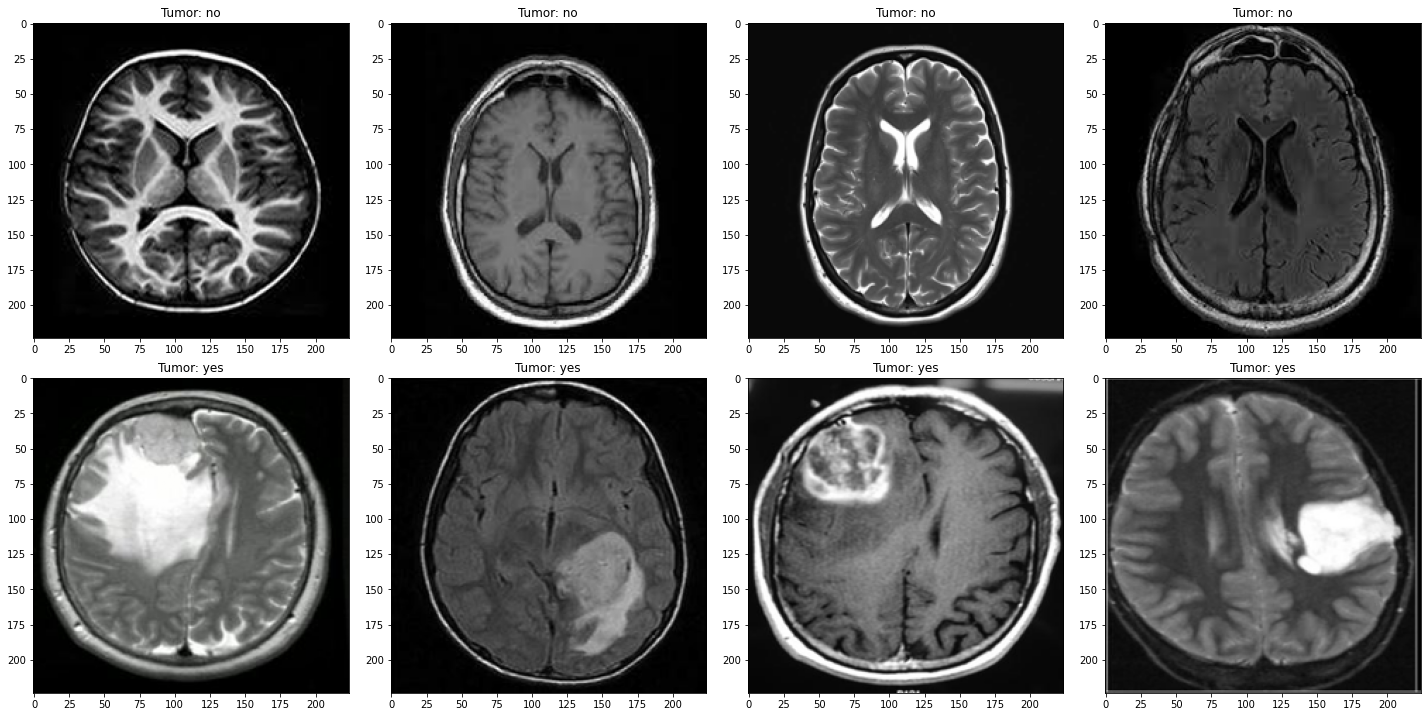

In [73]:
show_4x2_images()

Predictive models were designed, using the image data which was split into training, testing and validation sets. The first was a neural net which employed 5 dense layers. 15 epochs were trained and the configurations for the epoch with the best validation accuracy were saved. The second model was a convolutional neural network. It had 24 layers, using different activations for different laters. It was fitted on the data with 25 epochs. The third predictive model used VGG19 as the based model. It is a convolutional network with 19 layers and is often used for image recognition. This third model also used transfer learning, as the VGG19 model used was a pretrained version using more than a million images from the ImageNet database. The model is able to classify images into 1000 object categories. It is then used as a predictor for the presence of brain tumors in MRI images using the brain tumor dataset.

The three models were evaluated based on their predictive accuracy, f1_score, precision and recall. The results are displayed below. As can clearly be seen, the 2nd model was the best one. It had the best (highest) scores for all 4 evaluation metrics. Relative to the other predictive models, it had the most number of layers, as well as a wider variety of layer types (employed Conv2D, BatchNormalization and MaxPooling2D, not just Dense).

In [85]:
import pandas as pd 
data = {'model':['model_1', 'model_2', 'model_3'],
        "accuracy":  ["0.843137","0.862745","0.470588"],
        'f1_score':  ["0.841615","0.862745","0.320000"],
        "precision": ["0.845611","0.865741","0.235294"],
        "recall":    ["0.840278","0.865741","0.500000"]} 
df = pd.DataFrame(data) 
print(df) 

     model  accuracy  f1_score precision    recall
0  model_1  0.843137  0.841615  0.845611  0.840278
1  model_2  0.862745  0.862745  0.865741  0.865741
2  model_3  0.470588  0.320000  0.235294  0.500000


The best model from the AI model share leader board was from user “Taketo”. It has 5 epochs, and is configured with the following: 


"{'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}”

This is almost the same as the optimum configuration for my best model. The only difference is that ‘learning_rate’ = 1.5625e-05 . There are three visible layers in the model structure. However, upon further inspection, one of the layers contains hidden layers. The first layer is a hidden CNN model with multiple layers. The model was downloaded and configured using Taketo optimum configured. When then tested using the training and testing sets for my models, the results were a lot worse than expected. Below are the results for my best model and Taketo’s model.


In [86]:
import pandas as pd 
data = {'model':     ['my_model', 'Taketo_model', 'Taketo_model.fit'],
        "accuracy":  ["0.862745","0.941176","0.529412"],
        'f1_score':  ["0.862745","0.940812","0.346154"],
        "precision": ["0.865741","0.942547","0.264706"],
        "recall":    ["0.865741","0.939815","0.500000"]} 
df = pd.DataFrame(data) 
print(df)

              model  accuracy  f1_score precision    recall
0          my_model  0.862745  0.862745  0.865741  0.865741
1      Taketo_model  0.941176  0.940812  0.942547  0.939815
2  Taketo_model.fit  0.529412  0.346154  0.264706  0.500000
